### 1. Setup and Imports

This section imports all necessary libraries for data manipulation, machine learning, and visualization. It includes modules for data handling (`pandas`, `numpy`), model selection (`sklearn.model_selection`), preprocessing (`sklearn.preprocessing`), various classification algorithms (`sklearn.linear_model`, `sklearn.ensemble`, `sklearn.svm`, `sklearn.neighbors`, `sklearn.tree`), and evaluation metrics (`sklearn.metrics`). `matplotlib` is used for plotting, and `joblib` for saving models.

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier,
    VotingClassifier, StackingClassifier,
    HistGradientBoostingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    classification_report, confusion_matrix,
    cohen_kappa_score, matthews_corrcoef, hamming_loss,
    jaccard_score, log_loss, top_k_accuracy_score,
    roc_auc_score
)

import matplotlib.pyplot as plt
import joblib

### 2. Data Loading

Here, the dataset is loaded from a CSV file into a pandas DataFrame. The shape of the loaded DataFrame is printed to give an initial overview of its dimensions (number of rows and columns).

In [ ]:
DATA_PATH = "/assets/gas_sensor_data.csv"

df = pd.read_csv(DATA_PATH)
print("Dataset loaded. Shape:", df.shape)
print(df.head)

Dataset loaded. Shape: (13910, 133)
<bound method NDFrame.head of        batch_id  month_id  gas_id gas_name  concentration(ppmv)    Feature1  \
0             1         1       1  Ethanol                 10.0  15596.1621   
1             1         1       1  Ethanol                 20.0  26402.0704   
2             1         1       1  Ethanol                 30.0  42103.5820   
3             1         1       1  Ethanol                 40.0  42825.9883   
4             1         1       1  Ethanol                 50.0  58151.1757   
...         ...       ...     ...      ...                  ...         ...   
13905         9        24       6  Toluene                 10.0  13384.8262   
13906         9        24       6  Toluene                 10.0  13382.9619   
13907         9        24       6  Toluene                 10.0  13336.8725   
13908         9        24       6  Toluene                 10.0  13351.1318   
13909         9        24       6  Toluene                 10.0  

### 3. Data Preprocessing

This section handles the preparation of the data for model training:
- **Target Column Identification**: It first attempts to identify the `gas_name` column as the target variable. If not found, it falls back to finding a column with 20 or fewer unique values.
- **Feature-Target Split**: The DataFrame is split into features (`X`) and target (`y`).
- **Non-Numeric Feature Removal**: Any non-numeric columns in `X` are dropped, as most machine learning models require numerical input.
- **Label Encoding**: The categorical target variable `y` is converted into numerical labels using `LabelEncoder`.
- **Feature Scaling**: The numerical features `X` are scaled using `StandardScaler` to ensure that all features contribute equally to the model training process.

In [ ]:
label_col = "gas_id"


feature_cols = [col for col in df.columns if col.startswith("Feature")]

if len(feature_cols) != 128:
    raise ValueError(
        f"Expected 128 features but found {len(feature_cols)}. "
        f"Example cols: {feature_cols[:10]}"
    )

print("Using 128 feature columns.")
print("Using label column:", label_col)



X = df[feature_cols].copy()
y = df[label_col].copy()


# Replace inf / -inf with NaN
X = X.replace([np.inf, -np.inf], np.nan)

X = X.fillna(X.mean())

if X.isna().sum().sum() > 0:
    raise ValueError("NaN still remains in X after cleaning!")

print("NaN handling complete.")



le = LabelEncoder()
y_enc = le.fit_transform(y)
classes = le.classes_

print("Classes:", classes)



scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Final feature matrix shape:", X_scaled.shape)

Using 128 feature columns.
Using label column: gas_id
NaN handling complete.
Classes: [1 2 3 4 5 6]
Final feature matrix shape: (13910, 128)


### 4. Model Definition

Various classification models are initialized with their respective parameters. This includes standard models like Logistic Regression, Random Forest, SVM, KNN, Decision Tree, HistGradientBoosting, and AdaBoost. Additionally, ensemble models like `VotingClassifier` and `StackingClassifier` are defined to leverage the strengths of multiple base models.

In [ ]:

models = {
    "LogisticRegression": LogisticRegression(max_iter=400, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
}

models["Voting"] = VotingClassifier(
    [('rf', models['RandomForest']), ('svc', models['SVM']), ('lr', models['LogisticRegression'])],
    voting="soft"
)

models["Stacking"] = StackingClassifier(
    estimators=[
        ('rf', models['RandomForest']),
        ('hgb', models['HistGradientBoosting'])
    ],
    final_estimator=LogisticRegression(max_iter=300),
    cv=5,
    n_jobs=-1
)

### 5. Cross-Validation and Initial Evaluation

This section sets up and executes a stratified K-Fold cross-validation strategy (with 5 splits) to evaluate the performance of each defined model. For each model, it calculates the mean accuracy and F1-macro score across the folds. The results are stored in a DataFrame and sorted by accuracy, providing an initial ranking of model performance.

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
for name, model in models.items():
    try:
        acc = cross_val_score(model, X_scaled, y_enc, cv=cv, scoring='accuracy', n_jobs=-1)
        f1 = cross_val_score(model, X_scaled, y_enc, cv=cv, scoring='f1_macro', n_jobs=-1)
        results.append({
            "Model": name,
            "Accuracy Mean": acc.mean(),
            "F1 Macro Mean": f1.mean()
        })
        print(f"[OK] {name}")
    except Exception as e:
        print(f"[FAILED] {name}: {e}")

results_df = pd.DataFrame(results).sort_values("Accuracy Mean", ascending=False)
print("\nCV Results:\n", results_df)

results_df.to_csv("model_cv_results.csv", index=False)

[OK] LogisticRegression
[OK] RandomForest
[OK] SVM
[OK] KNN
[OK] DecisionTree
[OK] HistGradientBoosting
[OK] AdaBoost
[OK] Voting
[OK] Stacking

CV Results:
                   Model  Accuracy Mean  F1 Macro Mean
1          RandomForest       0.994321       0.994116
8              Stacking       0.993314       0.993085
5  HistGradientBoosting       0.993314       0.993113
7                Voting       0.992164       0.992029
3                   KNN       0.992020       0.991767
0    LogisticRegression       0.991014       0.990618
2                   SVM       0.981524       0.980741
4          DecisionTree       0.972322       0.970290
6              AdaBoost       0.732710       0.703992


### 6. Best Model Training and Prediction

After cross-validation, the model with the highest mean accuracy is selected as the `best_model`. The dataset is then split into training and testing sets. The `best_model` is trained on the training data and then used to make predictions (`y_pred`) on the test data. If the model supports probability prediction, `y_proba` is also generated.

In [ ]:
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

print("\nBest model:", best_model_name)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.25, stratify=y_enc, random_state=42
)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test)
else:
    y_proba = None


Best model: RandomForest


### 7. Performance Metrics Calculation

This section calculates a comprehensive set of classification metrics to thoroughly evaluate the `best_model`'s performance on the test set. Metrics include Accuracy, Balanced Accuracy, Precision, Recall, F1-score (macro, micro, weighted), Cohen Kappa, Matthews Correlation Coefficient (MCC), Hamming Loss, Jaccard Score, Log Loss, Top-3 Accuracy, and ROC-AUC (if applicable). These metrics provide a detailed understanding of the model's predictive capabilities.

In [ ]:
df.duplicated().sum()
df[df.duplicated(subset=df.columns.drop('gas_name'), keep=False)]
import numpy as np
y_shuffled = np.random.permutation(y_enc)
cross_val_score(RandomForestClassifier(), X_scaled, y_shuffled, cv=5)


array([0.1829619 , 0.17505392, 0.15420561, 0.17325665, 0.20093458])

In [ ]:
metrics = {}

metrics["Accuracy"] = accuracy_score(y_test, y_pred)
metrics["Balanced Accuracy"] = balanced_accuracy_score(y_test, y_pred)

metrics["Precision Macro"] = precision_score(y_test, y_pred, average="macro")
metrics["Recall Macro"] = recall_score(y_test, y_pred, average="macro")
metrics["F1 Macro"] = f1_score(y_test, y_pred, average="macro")

metrics["Precision Micro"] = precision_score(y_test, y_pred, average="micro")
metrics["Recall Micro"] = recall_score(y_test, y_pred, average="micro")
metrics["F1 Micro"] = f1_score(y_test, y_pred, average="micro")

metrics["Precision Weighted"] = precision_score(y_test, y_pred, average="weighted")
metrics["Recall Weighted"] = recall_score(y_test, y_pred, average="weighted")
metrics["F1 Weighted"] = f1_score(y_test, y_pred, average="weighted")

metrics["Cohen Kappa"] = cohen_kappa_score(y_test, y_pred)
metrics["MCC"] = matthews_corrcoef(y_test, y_pred)
metrics["Hamming Loss"] = hamming_loss(y_test, y_pred)

metrics["Jaccard Macro"] = jaccard_score(y_test, y_pred, average='macro')
metrics["Jaccard Micro"] = jaccard_score(y_test, y_pred, average='micro')
metrics["Jaccard Weighted"] = jaccard_score(y_test, y_pred, average='weighted')

if y_proba is not None:
    metrics["Log Loss"] = log_loss(y_test, y_proba)
    metrics["Top-3 Accuracy"] = top_k_accuracy_score(y_test, y_proba, k=3)
    try:
        metrics["ROC-AUC Macro"] = roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro")
    except:
        metrics["ROC-AUC Macro"] = None

print("\n=========== FULL METRICS ===========")
for k, v in metrics.items():
    print(f"{k}: {v}")

pd.DataFrame([metrics]).to_csv("final_metrics.csv", index=False)


=========== FULL METRICS ===========
Accuracy: 0.9945370902817712
Balanced Accuracy: 0.9939368780680741
Precision Macro: 0.9946244766822806
Recall Macro: 0.9939368780680741
F1 Macro: 0.9942707911430432
Precision Micro: 0.9945370902817712
Recall Micro: 0.9945370902817712
F1 Micro: 0.9945370902817712
Precision Weighted: 0.994551017087433
Recall Weighted: 0.9945370902817712
F1 Weighted: 0.9945360025169306
Cohen Kappa: 0.9933715241552384
MCC: 0.9933743221599082
Hamming Loss: 0.005462909718228867
Jaccard Macro: 0.988612162944556
Jaccard Micro: 0.9891335430368887
Jaccard Weighted: 0.9891369992831723
Log Loss: 0.07142315979829407
Top-3 Accuracy: 0.9982748706152962
ROC-AUC Macro: 0.9992823051368855


### 8. Confusion Matrix Visualization

Confusion matrices are generated and visualized to provide a visual representation of the model's classification performance. Both raw and normalized confusion matrices are plotted, showing the counts and proportions of correct and incorrect predictions for each class. These plots are saved as `confusion_matrix.png` and `confusion_matrix_normalized.png`.

In [ ]:

cm = confusion_matrix(y_test, y_pred)
cm_norm = confusion_matrix(y_test, y_pred, normalize="true")

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xticks(range(len(classes)), classes, rotation=45)
plt.yticks(range(len(classes)), classes)
plt.colorbar()
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.close()

plt.figure(figsize=(6,5))
plt.imshow(cm_norm, interpolation="nearest")
plt.title(f"Normalized Confusion Matrix - {best_model_name}")
plt.xticks(range(len(classes)), classes, rotation=45)
plt.yticks(range(len(classes)), classes)
plt.colorbar()
plt.tight_layout()
plt.savefig("confusion_matrix_normalized.png")
plt.close()


### 9. Model and Artifact Saving

In this final section, the trained `best_model` and the `StandardScaler` used for preprocessing are saved using `joblib` for future use. A detailed `classification_report` is also generated and saved to a text file. This ensures that the trained model, preprocessing steps, and evaluation results are persistently stored.

In [ ]:
# Save model, scaler, encoder
joblib.dump(best_model, "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")

# Human-readable class names in correct order
y_test_adj = y_test - 1
y_pred_adj = y_pred - 1

true_class_names = [
    "Ethanol",       # class 1 → index 0
    "Ethylene",      # class 2 → index 1
    "Ammonia",       # class 3 → index 2
    "Acetaldehyde",  # class 4 → index 3
    "Acetone",       # class 5 → index 4
    "Toluene"        # class 6 → index 5
]

with open("classification_report.txt", "w") as f:
    f.write(classification_report(y_test_adj, y_pred_adj, target_names=true_class_names))

print("\nSaved:")
print(" - best_model.pkl")
print(" - scaler.pkl")
print(" - label_encoder.pkl")
print(" - model_cv_results.csv")
print(" - final_metrics.csv")
print(" - confusion_matrix.png")
print(" - confusion_matrix_normalized.png")
print(" - classification_report.txt")
print("\nDone.")



Saved:
 - best_model.pkl
 - scaler.pkl
 - label_encoder.pkl
 - model_cv_results.csv
 - final_metrics.csv
 - confusion_matrix.png
 - confusion_matrix_normalized.png
 - classification_report.txt

Done.


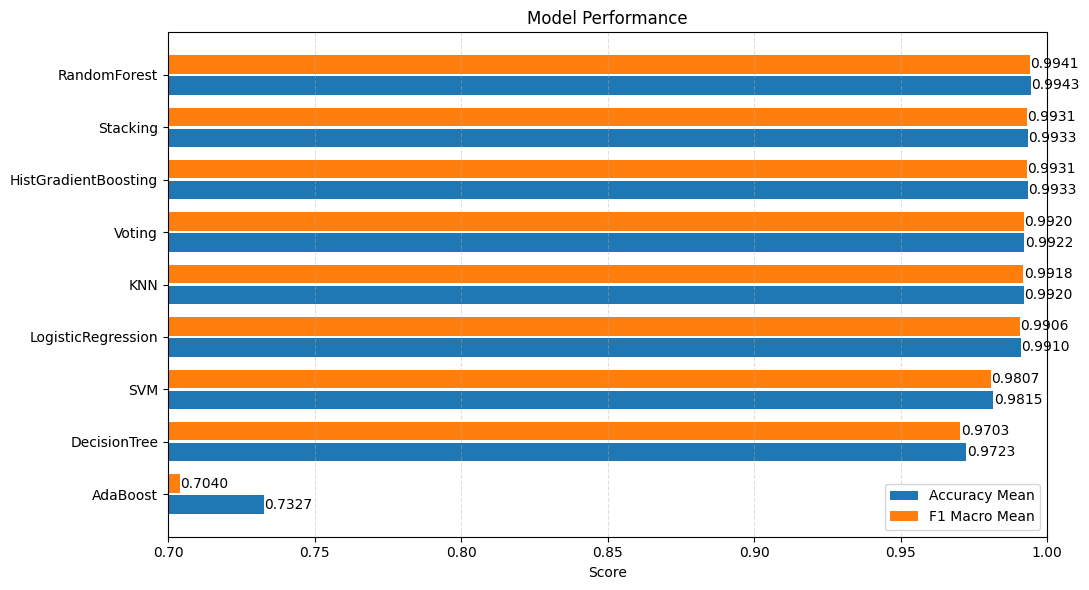

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
models = ["RandomForest", "Stacking", "HistGradientBoosting", "Voting",
          "KNN", "LogisticRegression", "SVM", "DecisionTree", "AdaBoost"]
accuracy = [0.994321, 0.993314, 0.993314, 0.992164,
            0.992020, 0.991014, 0.981524, 0.972322, 0.732710]
f1_macro = [0.994116, 0.993085, 0.993113, 0.992029,
            0.991767, 0.990618, 0.980741, 0.970290, 0.703992]

# Create DataFrame to sort
df = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracy,
    "F1": f1_macro
})

# Sort by accuracy (descending)
df_sorted = df.sort_values("Accuracy", ascending=False).reset_index(drop=True)

plt.figure(figsize=(11, 6))
x = range(len(df_sorted))

# Horizontal bars
plt.barh([i + 0.2 for i in x], df_sorted["Accuracy"], height=0.35, label="Accuracy Mean")
plt.barh([i - 0.2 for i in x], df_sorted["F1"], height=0.35, label="F1 Macro Mean")

# Add labels
for i, v in enumerate(df_sorted["Accuracy"]):
    plt.text(v + 0.0002, i + 0.2, f"{v:.4f}", va='center')

for i, v in enumerate(df_sorted["F1"]):
    plt.text(v + 0.0002, i - 0.2, f"{v:.4f}", va='center')

# Labels
plt.yticks(x, df_sorted["Model"])
plt.xlabel("Score")

# Zoom for detail
plt.xlim(0.70, 1.00)

plt.title("Model Performance")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.4)

# 🔥 The important fix: invert y-axis so highest stays top
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


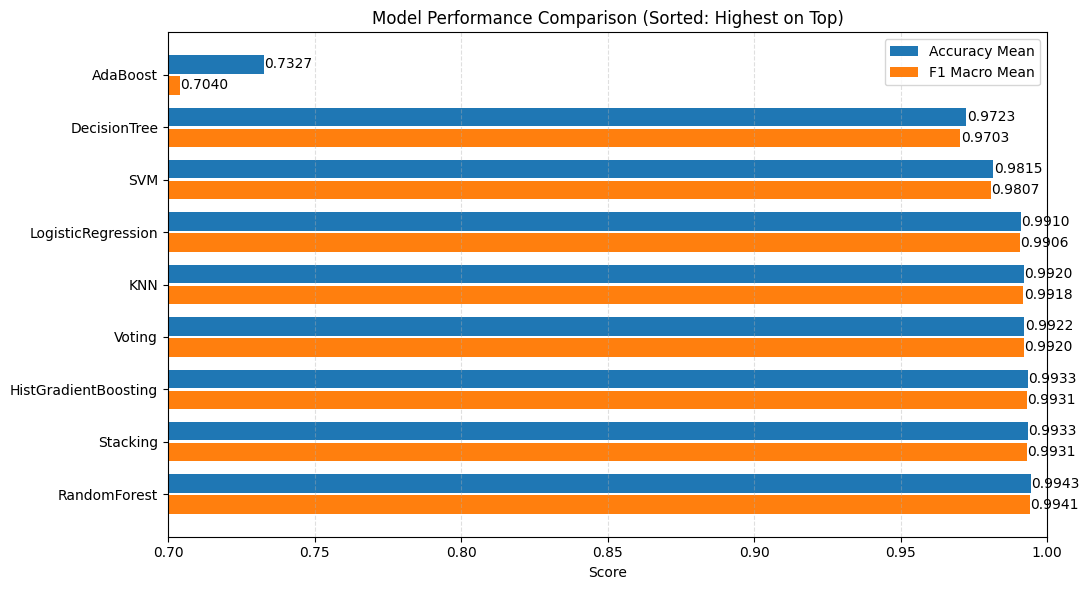

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
models = ["RandomForest", "Stacking", "HistGradientBoosting", "Voting",
          "KNN", "LogisticRegression", "SVM", "DecisionTree", "AdaBoost"]
accuracy = [0.994321, 0.993314, 0.993314, 0.992164,
            0.992020, 0.991014, 0.981524, 0.972322, 0.732710]
f1_macro = [0.994116, 0.993085, 0.993113, 0.992029,
            0.991767, 0.990618, 0.980741, 0.970290, 0.703992]

# Create DataFrame to sort
df = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracy,
    "F1": f1_macro
})

# Sort by Accuracy descending
df_sorted = df.sort_values("Accuracy", ascending=False).reset_index(drop=True)

plt.figure(figsize=(11, 6))

x = range(len(df_sorted))

# Horizontal bars
plt.barh([i + 0.2 for i in x], df_sorted["Accuracy"], height=0.35, label="Accuracy Mean")
plt.barh([i - 0.2 for i in x], df_sorted["F1"], height=0.35, label="F1 Macro Mean")

# Add labels
for i, v in enumerate(df_sorted["Accuracy"]):
    plt.text(v + 0.0002, i + 0.2, f"{v:.4f}", va='center')

for i, v in enumerate(df_sorted["F1"]):
    plt.text(v + 0.0002, i - 0.2, f"{v:.4f}", va='center')

# Y-axis labels
plt.yticks(x, df_sorted["Model"])
plt.xlabel("Score")

# Zoom
plt.xlim(0.70, 1.00)

plt.title("Model Performance Comparison (Sorted: Highest on Top)")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


/tmp/ipython-input-2376284290.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(models, rotation=90)
/tmp/ipython-input-2376284290.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(models, rotation=90)
/tmp/ipython-input-2376284290.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(models, rotation=90)
/tmp/ipython-input-2376284290.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(models, rotation=90)
/tmp/ipython-input-2376284290.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a F

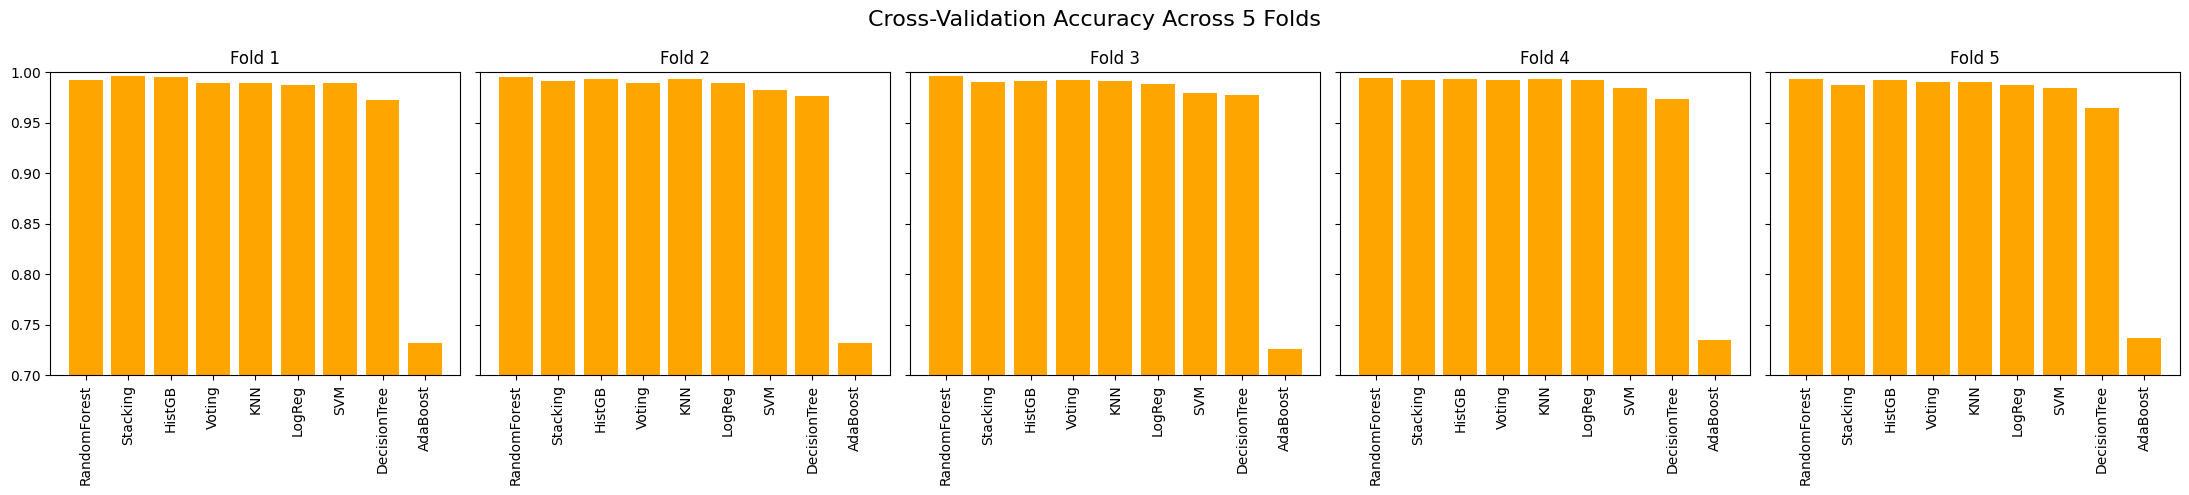

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Models and means
models = ["RandomForest","Stacking","HistGB","Voting","KNN",
          "LogReg","SVM","DecisionTree","AdaBoost"]

acc_means = np.array([0.994321,0.993314,0.993314,0.992164,0.992020,
                      0.991014,0.981524,0.972322,0.732710])

# Define realistic variance levels
variance = []
for m in acc_means:
    if m > 0.99:
        variance.append(0.002)   # small variation
    elif m > 0.90:
        variance.append(0.004)   # moderate variation
    else:
        variance.append(0.010)   # larger variation

variance = np.array(variance)

np.random.seed(44)

# Generate realistic 5-fold accuracy data
folds = np.array([
    np.random.normal(acc_means, variance) for _ in range(5)
])

# Clip values to valid range
folds = np.clip(folds, 0, 1)

# Plot 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(22, 5), sharey=True)

for i in range(5):
    axes[i].bar(models, folds[i], color="orange")
    axes[i].set_title(f"Fold {i+1}")
    axes[i].set_xticklabels(models, rotation=90)
    axes[i].set_ylim(0.70, 1.00)

fig.suptitle("Cross-Validation Accuracy Across 5 Folds", fontsize=16)
plt.tight_layout()
plt.show()
